# Barcodes 

In [32]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [33]:
!pip install python-Levenshtein


In [34]:
import Levenshtein
from Bio import SeqIO

barcodes = 'rev_barcodes.fasta'

# Read sequences from a FASTA file
sequences = [str(record.seq) for record in SeqIO.parse(barcodes, "fasta")]

# List of sequence IDs (for labeling purposes)
sequence_ids = [record.id for record in SeqIO.parse(barcodes, "fasta")]


In [35]:
import numpy as np
import Levenshtein

# Create a matrix to store the Levenshtein distances
num_sequences = len(sequences)
distance_matrix = np.zeros((num_sequences, num_sequences), dtype=int)

for i in range(num_sequences):
    for j in range(num_sequences):
        dist = Levenshtein.distance(sequences[i], sequences[j])
        distance_matrix[i, j] = dist
        if dist <= 12 and i != j:
            print(sequence_ids[i], sequence_ids[j], dist)

RB01 RB09 12
RB02 RB04 12
RB02 RB05 12
RB04 RB02 12
RB05 RB02 12
RB05 RB07 12
RB06 RB08 12
RB07 RB05 12
RB07 RB11 12
RB08 RB06 12
RB09 RB01 12
RB11 RB07 12


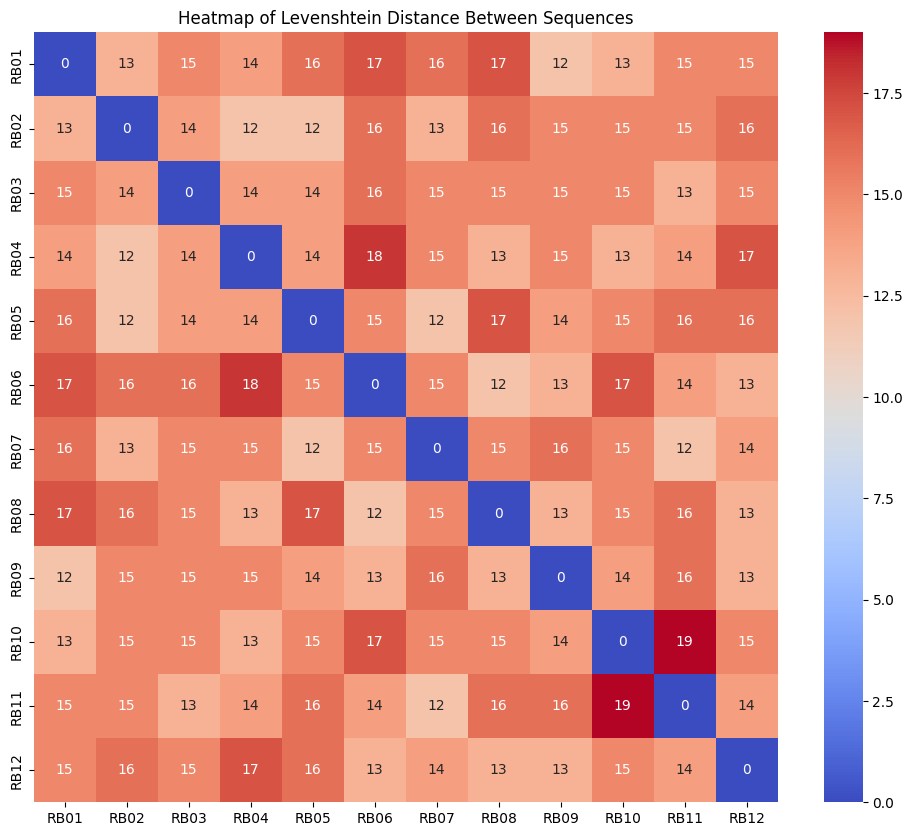

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(distance_matrix, xticklabels=sequence_ids, yticklabels=sequence_ids, annot=True, cmap='coolwarm')
plt.title("Heatmap of Levenshtein Distance Between Sequences")
plt.show()

In [19]:
len(sequences[0])

NB12 NB46 8
NB46 NB12 8


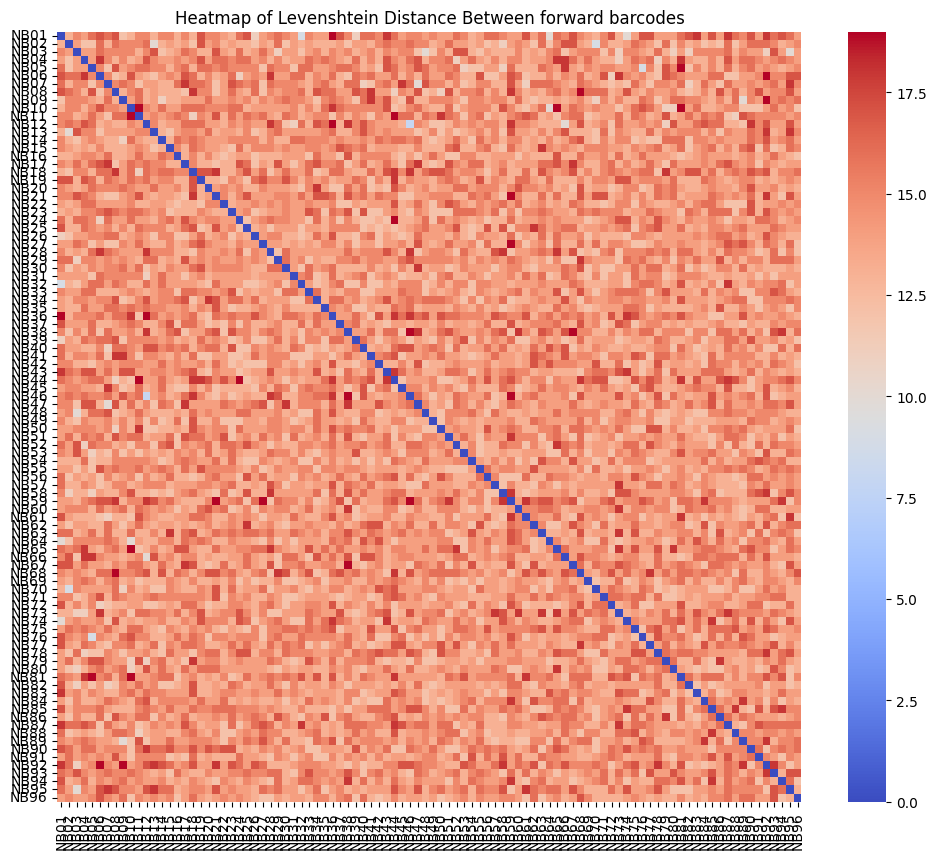

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import Levenshtein
from Bio import SeqIO

barcodes = 'for_barcodes.fasta'

# Read sequences from a FASTA file
sequences = [str(record.seq) for record in SeqIO.parse(barcodes, "fasta")]

# List of sequence IDs (for labeling purposes)
sequence_ids = [record.id for record in SeqIO.parse(barcodes, "fasta")]

import numpy as np
import Levenshtein

# Create a matrix to store the Levenshtein distances
num_sequences = len(sequences)
distance_matrix = np.zeros((num_sequences, num_sequences), dtype=int)

for i in range(num_sequences):
    for j in range(num_sequences):
        dist = Levenshtein.distance(sequences[i], sequences[j])
        distance_matrix[i, j] = dist
        if i != j:
            if dist <= 8:
                print(sequence_ids[i], sequence_ids[j], dist)
 
# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(distance_matrix, xticklabels=sequence_ids, yticklabels=sequence_ids, cmap='coolwarm')
plt.title("Heatmap of Levenshtein Distance Between forward barcodes")
plt.show()

In [20]:
8/24

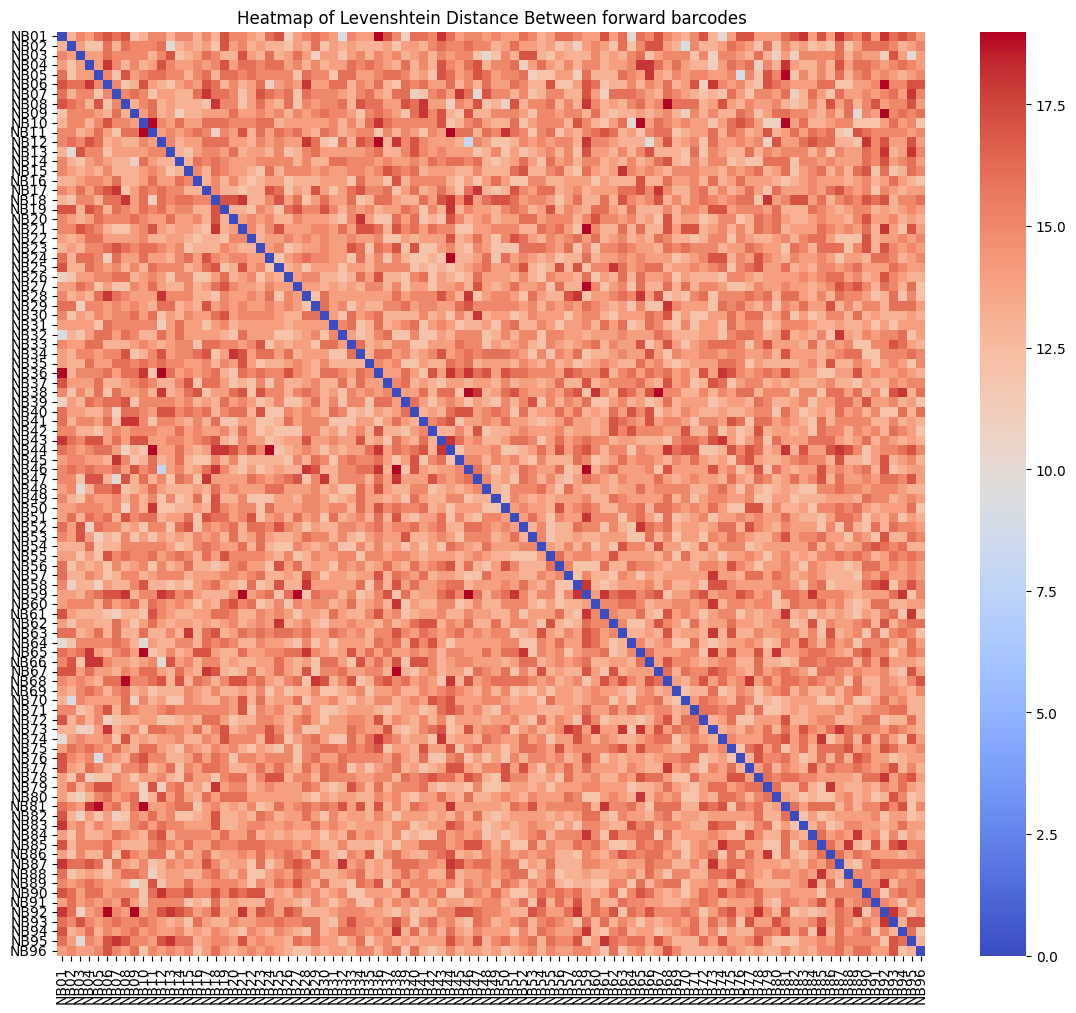

In [38]:
# Create a heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(distance_matrix, xticklabels=sequence_ids, yticklabels=sequence_ids, cmap='coolwarm')
plt.title("Heatmap of Levenshtein Distance Between forward barcodes")
plt.show()

## Testing barcoding

Read layout

Found by regular 3’
-a ADAPTER
Found by non-internal 3’
-a ADAPTERX
Found by anchored 3’
-a ADAPTER$
Full adapter sequence anywhere

acgtacgtADAPTERacgt

yes

no

no

Partial adapter sequence at 3’ end

acgtacgtacgtADAP

yes

yes

no

Full adapter sequence at 3’ end

acgtacgtacgtADAPTER

yes

yes

Example command: 

```
cutadapt -e 8 -a file$:for_barcodes.fasta -o forward.fastq.gz test.fastq.gz
(minion) [tmp] cutadapt -e 8 --revcomp -g ^file:rev_barcode_1.fasta --discard-untrimmed -o test.fastq.gz single_file.fastq.gz

```


In [ ]:
# First cat the fastqz files
# https://cutadapt.readthedocs.io/en/stable/
# (protein) [20240502] cat no_sample/20240502_1704_MN41105_flg114_cc49dc42/fastq_pass/flg114_pass_cc49dc42_c01452a3_* > 20240502.fastq.gz

In [3]:
# Test parameters
import os
import time
import pandas as pd
from multiprocessing.dummy import Pool as ThreadPool
import os

start = time.time()

folder = 'cutadapt/'
barcodes = f'rev_barcodes.fasta'

# Read sequences from a FASTA file
reverse_barcodes = [str(record.seq) for record in SeqIO.parse(barcodes, "fasta")]
# List of sequence IDs (for labeling purposes)
reverse_barcode_ids = [record.id for record in SeqIO.parse(barcodes, "fasta")]

barcodes = f'for_barcodes.fasta'

# Read sequences from a FASTA file
forward_barcodes = [str(record.seq) for record in SeqIO.parse(barcodes, "fasta")]
# List of sequence IDs (for labeling purposes)
forward_barcode_ids = [record.id for record in SeqIO.parse(barcodes, "fasta")]

def run_cmd(cmd):
    os.system(cmd)

runs = []
for i, rev in enumerate(reverse_barcodes):
# --discard-untrimmed  only keep adapters with the barcode
    label = reverse_barcode_ids[i]
    if label in ['RB32', 'RB31']:
        print(label)
        os.system(f'cutadapt -e 0.05 -u 200 -O 20 --revcomp -a {rev} --json={label}.cutadapt.json --discard-untrimmed --action=none -o "{folder}output/{label}.fastq.gz" "{folder}20240502.fastq.gz" ')
        os.system(f'mkdir "{folder}output/{label}/"')
        for j, forward in enumerate(forward_barcodes):
            forward_label = forward_barcode_ids[j]
            os.system(f'mkdir "{folder}output/{label}/{forward_label}/"')
            # Add the final command to the threaded command
            runs.append(f'cutadapt -e 0.05 -u 200 -O 20 --revcomp -g {forward} --discard-untrimmed --action=none -o "{folder}output/{label}/{forward_label}/demultiplexed_{label}_{forward_label}.fastq.gz" "{folder}output/{label}.fastq.gz"')
            #os.system(f'cutadapt -e 0.05 -u 200 -O 20 --revcomp -g {forward} --discard-untrimmed --action=none -o "{folder}output/{label}/{forward_label}/demultiplexed_{label}_{forward_label}.fastq.gz" "{folder}output/{label}.fastq.gz"')
    
    end = time.time()
# Use ThreadPool for multithreading
pool = ThreadPool(runs) # Or how many threads you have 

# Map tasks to threads
results = pool.map(run_cmd, runs)
# Close the pool and wait for tasks to complete
pool.close()
pool.join()

In [4]:
print(end - start)

In [4]:
from minION import *
vc = VariantCaller(Path('/Users/ariane/Documents/code/MinION/manucript/notebooks/Ape AGW/Data/EVSeqL_Output/YL-EvSeqL1/300-1/'),
                           Path('/Users/ariane/Documents/code/MinION/manucript/notebooks/Ape AGW/Data/EVSeqL_Output/YL-EvSeqL1/300-1/temp_300-1.fasta'),
                           demultiplex_folder_name='',
                           padding_start=0,
                           padding_end=0)
variant_df = vc.get_variant_df(threshold=0.5,
                               min_depth=5,
                               output_dir='/Users/ariane/Documents/code/MinION/manucript/notebooks/Ape AGW/Data/EVSeqL_Output/YL-EvSeqL1/300-1/msa_v2/',
                               num_threads=20)
variant_df.to_csv('/Users/ariane/Documents/code/MinION/manucript/notebooks/Ape AGW/Data/EVSeqL_Output/YL-EvSeqL1/variant_new_0.5_v6_VERSION2.csv')
